In [1]:
from __future__ import print_function
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data
import matplotlib.pyplot as plt

from model import PMF
from evaluations import RMSE

print('------------------------ Train PMF ---------------------------')
# --------------------------------------------- HYPERPARAMETERS ----------------------------------------------------
# Input batch size for training
batch_size = 100000
# Number of maximum epoches to train
epoches = 150
# Enables CUDA training
no_cuda = False
# Generate random seed
seed = 1
# Weight decay
weight_decay = 0.1
# Size of embedding features
embedding_feature_size = 100
# Training ratio
ratio = 0.8
# Learning rate
lr = 0.0001
# Momentum value
momentum = 0.9
# ------------------------------------------------------------------------------------------------------------------

# Load datasets
user = pickle.load(open('dataset/user_id_to_num.pkl', 'rb'))
print("Loaded user")
rest = pickle.load(open('dataset/rest_id_to_num.pkl', 'rb'))
print("Loaded rest")
data = np.load('dataset/data.npy', allow_pickle=True)
print("Loaded data")

# Normalize rewards to [-1, 1]
data[:,0] = 0.5*(data[:,0] - 3)

# Shuffle data
np.random.shuffle(data)

# Split data
train_data = data[:int(ratio*data.shape[0])]
print(f"DEBUG: train data size: {train_data.shape}")
vali_data = data[int(ratio*data.shape[0]):int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data[int((ratio+(1-ratio)/2)*data.shape[0]):]

# Extract number of users and items
NUM_USERS = len(user)
NUM_ITEMS = len(rest)

# Get CUDA device if available
cuda = torch.cuda.is_available()

# Set device to CUDA or CPU, depending on availability and desire
device = torch.device("cuda" if cuda and no_cuda else "cpu")

# Generate and apply seeds
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)

# Specify number of workers for cuda
kwargs = {'num_workers':2, 'pin_memory':True} if cuda else {}

# Construct Data Loaders
train_data_loader = torch.utils.data.DataLoader(torch.from_numpy(train_data), batch_size=batch_size, shuffle=False, **kwargs)
test_data_loader = torch.utils.data.DataLoader(torch.from_numpy(test_data), batch_size=batch_size, shuffle=False, **kwargs)

# Initialize model
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, no_cuda=no_cuda)
# print(f"DEBUG: # Initialize model: n_users = {NUM_USERS}, n_items = {NUM_ITEMS}", )

# Move model to CUDA if CUDA selected
if cuda:
    model.cuda()
    print("Model moved to CUDA")

# Set loss function
loss_function = nn.MSELoss(reduction='sum')

# Set optimizer (uncomment Adam for adam)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Function for training one epoch
def train(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()

    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # print("DEBUG: start batch #{batch_idx}")
        # Zero optimizer gradient
        optimizer.zero_grad()

        # Extract user_id_nums: row, item_id_nums: col, ratings: val
        row = ele[:, 4]
        col = ele[:, 6]
        val = ele[:, 0]

        # print(row.shape, col.shape)

        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())

        # Move data to CUDA
        if cuda:
            row = row.cuda()
            col = col.cuda()
            val = val.cuda()

        # Train
        preds = model.forward(row, col)
        loss = loss_function(preds, val)
        loss.backward()
        optimizer.step()

        # Update epoch loss
        epoch_loss += loss.data
    # print("DEBUG: done")
    epoch_loss /= train_data_loader.dataset.shape[0]
    return epoch_loss

------------------------ Train PMF ---------------------------
Loaded user
Loaded rest
Loaded data
DEBUG: train data size: (5592153, 7)


In [2]:
# training model part
print('------------------------------------------- Training Model------------------------------------------------')
train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print('parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}'.format(ratio, batch_size, epoches, weight_decay))
print(model)

# Go through epochs
for epoch in range(1, epoches+1):

    # Train epoch
    train_epoch_loss = train(epoch, train_data_loader)

    # Get epoch loss
    train_loss_list.append(train_epoch_loss.cpu())

    # Move validation data to CUDA
    if cuda:
        vali_row = Variable(torch.from_numpy(vali_data[:, 4]).long()).cuda()
        vali_col = Variable(torch.from_numpy(vali_data[:, 6]).long()).cuda()
    else:
        vali_row = Variable(torch.from_numpy(vali_data[:, 4]).long())
        vali_col = Variable(torch.from_numpy(vali_data[:, 6]).long())

    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)

    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss.cpu())

    # Calculate validation rmse loss
    if cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), vali_data[:, 1])
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), vali_data[:, 1])

    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)

    print('Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}'. \
              format(epoch, train_rmse, vali_rmse))

    # # Early stop condition
    # if last_vali_rmse and last_vali_rmse < vali_rmse:
    #     break
    # else:
    #   last_vali_rmse = vali_rmse

------------------------------------------- Training Model------------------------------------------------
parameters are: train ratio:0.800000,batch_size:100000, epoches:150, weight_decay:0.100000
PMF(
  (user_embeddings): Embedding(1987843, 100)
  (item_embeddings): Embedding(150346, 100)
  (ub): Embedding(1987843, 1)
  (ib): Embedding(150346, 1)
)


/tmp/ipykernel_6487/1837992207.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(train_epoch_loss.cpu())


Training epoch: 1, training rmse: 0.728194, vali rmse:2.131742
Training epoch: 2, training rmse: 0.697766, vali rmse:2.128403
Training epoch: 3, training rmse: 0.682323, vali rmse:2.127597
Training epoch: 4, training rmse: 0.671619, vali rmse:2.127524
Training epoch: 5, training rmse: 0.663321, vali rmse:2.127726
Training epoch: 6, training rmse: 0.656507, vali rmse:2.128039
Training epoch: 7, training rmse: 0.650709, vali rmse:2.128393
Training epoch: 8, training rmse: 0.645653, vali rmse:2.128758
Training epoch: 9, training rmse: 0.641163, vali rmse:2.129119
Training epoch: 10, training rmse: 0.637119, vali rmse:2.129469
Training epoch: 11, training rmse: 0.633436, vali rmse:2.129805
Training epoch: 12, training rmse: 0.630051, vali rmse:2.130127
Training epoch: 13, training rmse: 0.626917, vali rmse:2.130433
Training epoch: 14, training rmse: 0.623995, vali rmse:2.130725
Training epoch: 15, training rmse: 0.621257, vali rmse:2.131004
Training epoch: 16, training rmse: 0.618677, vali

------------------------------------------- Testing Model------------------------------------------------
Test rmse: 5.007613


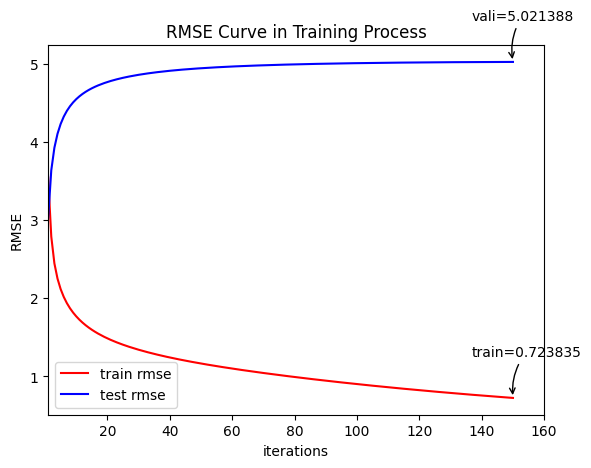

In [4]:
print('------------------------------------------- Testing Model------------------------------------------------')

# Move test set to CUDA
if cuda:
    test_row = Variable(torch.from_numpy(test_data[:, 4]).long()).cuda()
    test_col = Variable(torch.from_numpy(test_data[:, 6]).long()).cuda()
else:
    test_row = Variable(torch.from_numpy(test_data[:, 4]).long())
    test_col = Variable(torch.from_numpy(test_data[:, 6]).long())

# Get test predictions
preds = model.predict(test_row, test_col)

# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_data[:, 1])
else:
    test_rmse = RMSE(preds.data.numpy(), test_data[:, 1])
print('Test rmse: {:f}'.format(test_rmse))

# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color='r', label='train rmse')
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color='b', label='test rmse')
plt.legend()
plt.annotate(r'train=%f' % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.annotate(r'vali=%f' % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE Curve in Training Process')
plt.show()

# Save model
path_to_trained_pmf = 'dataset/data_runs/ratio_{:f}_bs_{:d}_e_{:d}_wd_{:f}_lr_{:f}_trained_pmf.pt'.format(ratio, batch_size, len(train_rmse_list), weight_decay, lr)
torch.save(model.state_dict(), path_to_trained_pmf)